In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyCloudy as pc
%matplotlib inline
pc.config.cloudy_exe = '/usr/local/Cloudy/cloudy-Tokyo24/source/cloudy.exe'

2024-08-03 18:11:46.271078: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/christophemorisset/anaconda3/envs/ML/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## A small grid of models is done, with varying the ionizing SED

In [2]:
# Teff = 30,000K
Min = pc.CloudyInput('../models/M2_1')
Min.set_BB(Teff=30000, lumi_unit='ionization parameter', lumi_value=-2)
Min.set_cste_density(0)
Min.set_stop(('zone = 1'))
Min.set_other(('Cosmic Rays Background', 'set dr 0'))
Min.print_input()

In [3]:
# Teff = 50,000K. No need to redefine all the parameter, only the name and SED are changed 
Min.model_name = '../models/M2_2'
Min.set_star() # This is needed to reset the SED. Otherwise, this SED is ADDED to the previous one.
Min.set_BB(Teff=50000, lumi_unit='ionization parameter', lumi_value=-2)
Min.print_input()

In [4]:
# Teff = 100,000K
Min.model_name = '../models/M2_3'
Min.set_star()
Min.set_BB(Teff=100000, lumi_unit='ionization parameter', lumi_value=-2)
Min.print_input()

In [5]:
# Teff = 160,000K
Min.model_name = '../models/M2_4'
Min.set_star()
Min.set_BB(Teff=160000, lumi_unit='ionization parameter', lumi_value=-2)
Min.print_input()

In [6]:
# A power law
Min.model_name = '../models/M2_5'
Min.set_star()
Min.set_star(SED = 'table power law', SED_params = '', 
             lumi_unit='ionization parameter', lumi_value=-2)
Min.print_input()

In [7]:
# AGN spectum
Min.model_name = '../models/M2_6'
Min.set_star()
Min.set_star(SED = 'table AGN', SED_params = '', lumi_unit='ionization parameter', lumi_value=-2)
Min.print_input()

In [8]:
# The 6 models are run in parallel
pc.run_cloudy(dir_='../models', n_proc=6, use_make=True, model_name='M2_')

In [10]:
M = pc.CloudyModel('../models/M2_1', cloudy_version_major=24)

warng CloudyModel ../models/M2_1: ../models/M2_1.emis does not exist.


In [11]:
# Reading the 6 model outputs into a list of CloudyModel objects
Ms = pc.load_models('../models/M2_*', read_emis=False, verbose=True, cloudy_version_major=24)

../models/M2_3 model read
../models/M2_2 model read
../models/M2_1 model read
../models/M2_5 model read
../models/M2_4 model read
../models/M2_6 model read


In [12]:
print(Ms)

[<Cloudy model from ../models/M2_3>, <Cloudy model from ../models/M2_2>, <Cloudy model from ../models/M2_1>, <Cloudy model from ../models/M2_5>, <Cloudy model from ../models/M2_4>, <Cloudy model from ../models/M2_6>]


In [13]:
# Some useful functions are available. This one extract a string from anoter string
from pyCloudy.utils.misc import sextract
# Have a look at the SED1 output. We are looking at the average nu value <nu>
M = Ms[0]
M.out

{'Cloudy ends': ' Cloudy ends: 1 zone, 1 iteration, 4 cautions. (single thread) ExecTime(s) 51.09\n',
 'stop': '   Calculation stopped because NZONE reached. Iteration 1 of 1\n',
 'Blackbody': '                       * Blackbody 100000.000000                                                         *\n',
 'hden': '                       * hden = 0.000                                                                    *\n',
 'SED1': '           I(nu>1ryd):  -1.8470   Average nu:2.176E+00   I( X-ray): -12.1206   I(BalC):  -2.7808     Phi(BalmrC):   8.0609\n',
 'SED2': '           phi(1.0-1.8): 8.1272   phi(1.8-4.0):  8.171   phi(4.0-20):  7.244   phi(20--): -2.786     Ion pht flx:2.998E+08\n',
 'SED3': '           I(gam ray):   0.0000   phi(gam r):   0.0000   I(Infred):  -4.3651   Alf(ox):   0.0000     Total inten:  -1.7980\n',
 'SED4': '           U(1.0----):1.000E-02   U(4.0----):5.846E-04   T(En-Den):2.895E+00   T(Comp):9.580E+04     nuJnu(912A):3.958E-03\n',
 'SED5': '           Occ(F

In [14]:
# Using list comprehension to define some lists
mean_Es = [np.float(sextract(M.out['SED1'], 'Average nu:', 'I(')) for M in Ms]
T0s = [M.T0 for M in Ms]
for mean_E, T0 in zip(mean_Es, T0s):
    print(mean_E,T0)

2.176 10446.000000000002
1.49 6482.900000000001
1.258 5672.800000000001
9.206 17728.0
3.091 15120.0
3.035 11740.0


/var/folders/7b/7gktm_g91hn54p3gxj15kb1m0000gn/T/ipykernel_41147/3857430167.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mean_Es = [np.float(sextract(M.out['SED1'], 'Average nu:', 'I(')) for M in Ms]


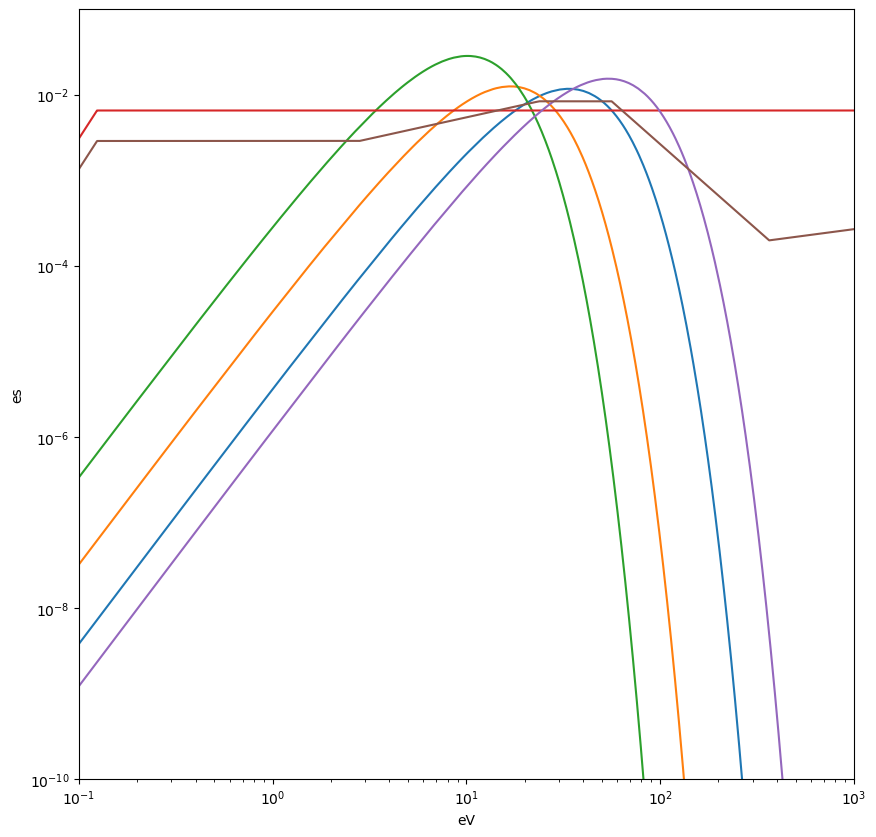

In [15]:
# Plot all the input spectra
f, ax = plt.subplots(figsize=(10,10))
for M in Ms:
    M.plot_spectrum(ax=ax)
ax.set_xlim((0.1, 1000))
ax.set_ylim((1e-10, 1e-1));

Text(0, 0.5, 'Te [K]')

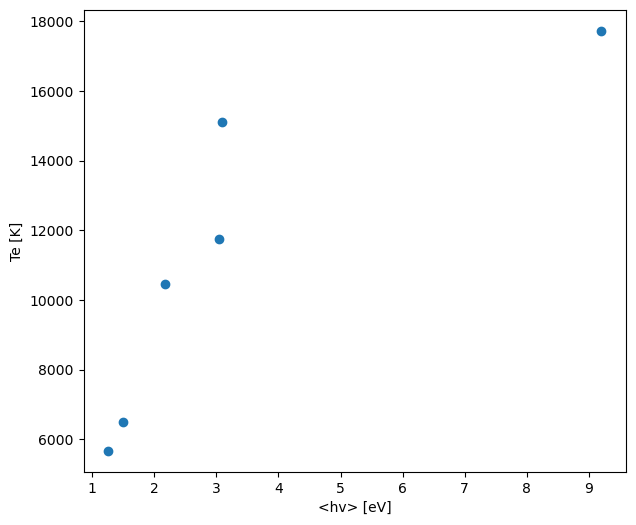

In [16]:
# lot the variation of the electron temperature versus 
# the average energy of the incomming ionizing photons
f, ax = plt.subplots(figsize=(7,6))
ax.scatter(mean_Es, T0s)
ax.set_xlabel('<hv> [eV]')
ax.set_ylabel('Te [K]')